In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from random import choices, sample
from gensim.models import Word2Vec
import gc
pd.set_option('display.float_format',lambda x : '%.2f' % x)
from math import log10

In [2]:
with open('./NN_result/lt_df_NN_rank_9days.pkl', 'rb') as file:
    lt_df_NN_rank = pickle.load(file)

In [3]:
full_table = pd.concat(lt_df_NN_rank[1:1+4], ignore_index=True)

In [4]:
full_table

,target,next,rank,NN_rank
0,2063176,1793668,53.00,21
1,1036421,215370,26.00,73
2,1036421,215370,26.00,73
3,4364467,632080,19.00,35
4,632080,4272037,20.00,29
...,...,...,...,...
952774,3087929,3292913,88.00,13
952775,4082039,3801509,48.00,49
952776,932794,488456,80.00,25
952777,1354952,1846009,39.00,2


In [5]:
full_table.describe()

,rank,NN_rank
count,952779.00,952779.00
mean,30.48,33.68
std,28.11,28.53
min,1.00,1.00
25%,6.00,9.00
50%,21.00,26.00
75%,50.00,54.00
max,99.00,99.00


In [6]:
table_grby = full_table.groupby(['target'])
pd.DataFrame(table_grby.size())

,0
target,
100000,1
1000061,1
100021,3
1000294,1
1000300,22
...,...
999686,1
999712,77
999752,1


In [7]:
df_table  = pd.merge(full_table, pd.DataFrame(table_grby.size()), on=['target'], how='left')

In [8]:
df_table.rename(columns = {0:'occur'}, inplace=True)

In [9]:
df_table.drop_duplicates(inplace=True, ignore_index=True)
df_table

,target,next,rank,NN_rank,occur
0,2063176,1793668,53.00,21,35
1,1036421,215370,26.00,73,3
2,4364467,632080,19.00,35,342
3,632080,4272037,20.00,29,648
4,4272037,2454050,14.00,26,99
...,...,...,...,...,...
308931,2800976,4243503,76.00,89,12
308932,3367985,3066223,25.00,13,68
308933,117092,4597783,91.00,28,139
308934,626850,3821357,10.00,18,53


In [10]:
df_table.describe()

,rank,NN_rank,occur
count,308936.00,308936.00,308936.00
mean,39.25,42.30,76.66
std,28.98,29.00,143.12
min,1.00,1.00,1.00
25%,13.00,17.00,6.00
50%,34.00,38.00,25.00
75%,63.00,66.00,84.00
max,99.00,99.00,2275.00


In [11]:
df_table.groupby('occur').mean().describe()

,rank,NN_rank
count,547.00,547.00
mean,37.62,38.27
std,5.38,4.61
min,11.33,17.44
25%,35.58,36.01
50%,38.01,38.71
75%,40.65,40.77
max,49.36,55.21


In [12]:
# df_table.groupby('occur').mean().to_excel('result_-8days_v3.xlsx')

In [13]:
# df_table.groupby('occur').mean().to_csv('result_-107days.csv')

In [14]:
# df_table.groupby('occur').mean().plot(figsize=(20,10))[:100]

---

In [15]:
target_grby = df_table.groupby(['target'])
target_grby.get_group('117092')['rank'].mean()

33.8

In [16]:
target_array = df_table['target'].unique()
training_table = pd.DataFrame({'target': target_array})
training_table  = pd.merge(training_table, pd.DataFrame(table_grby.size()), on=['target'], how='left')
training_table.rename(columns = {0:'occur'}, inplace=True)

In [17]:
training_table['rank'] = training_table.apply(lambda df: target_grby.get_group(df['target'])['rank'].mean(), axis=1)
training_table['NN_rank'] = training_table.apply(lambda df: target_grby.get_group(df['target'])['NN_rank'].mean(), axis=1)
training_table['label'] = training_table.apply(lambda df: df['rank'] > df['NN_rank'], axis=1)

In [18]:
training_table['switch'] = training_table.apply(lambda df: df['NN_rank'] if df['rank'] > df['NN_rank'] else df['rank'], axis=1)

In [19]:
training_table

,target,occur,rank,NN_rank,label,switch
0,2063176,35,33.25,40.75,False,33.25
1,1036421,3,52.50,51.00,True,51.00
2,4364467,342,28.70,38.46,False,28.70
3,632080,648,34.33,35.59,False,34.33
4,4272037,99,21.71,39.50,False,21.71
...,...,...,...,...,...,...
67298,518237,1,44.00,54.00,False,44.00
67299,3580767,1,69.00,63.00,True,63.00
67300,3938629,1,56.00,97.00,False,56.00
67301,4464701,1,3.00,71.00,False,3.00


In [20]:
training_table['label'].value_counts()

False    38440
True     28863
Name: label, dtype: int64

---

In [34]:
df_table_testday = pd.concat(lt_df_NN_rank[1+4:], ignore_index=True)

In [35]:
df_table_testday.drop_duplicates(inplace=True, ignore_index=True)

In [36]:
df_table_testday.describe()

,rank,NN_rank
count,308215.00,308215.00
mean,39.75,42.79
std,29.02,29.08
min,1.00,1.00
25%,14.00,17.00
50%,35.00,39.00
75%,63.00,67.00
max,99.00,99.00


In [62]:
switch_table = training_table.drop(columns=['rank', 'NN_rank', 'switch'])

In [71]:
df_table_testday_switch = pd.merge(df_table_testday, switch_table, on=['target'], how='left')

In [72]:
df_table_testday_switch['real_label'] = df_table_testday_switch.apply(lambda df: df['rank'] > df['NN_rank'], axis=1)

In [73]:
df_table_testday_switch['switch'] = df_table_testday_switch.apply(lambda df: df['NN_rank'] if df['label'] else df['rank'], axis=1)

In [74]:
df_table_testday_switch['switch_fill'] = df_table_testday_switch.apply(lambda df: df['rank'] if df['switch'] is np.NaN else df['switch'], axis=1)

In [75]:
df_table_testday_switch

,target,next,rank,NN_rank,occur,label,real_label,switch,switch_fill
0,4449648,1580138,77.00,49,5.00,False,True,77.00,77.00
1,1674582,3574186,54.00,61,38.00,True,False,61.00,61.00
2,3715112,1712849,2.00,24,1026.00,True,False,24.00,24.00
3,1712849,3715112,1.00,99,40.00,False,False,1.00,1.00
4,3715112,4546029,14.00,9,1026.00,True,True,9.00,9.00
...,...,...,...,...,...,...,...,...,...
308210,3244585,46310,52.00,74,6.00,True,False,74.00,74.00
308211,3586172,3904916,73.00,3,1.00,True,True,3.00,3.00
308212,1322280,1535093,68.00,68,nan,NaN,False,68.00,68.00
308213,3670405,845698,72.00,77,nan,NaN,False,77.00,77.00


In [76]:
df_table_testday_switch.describe()

,rank,NN_rank,occur,switch,switch_fill
count,308215.00,308215.00,282685.00,308215.00,308215.00
mean,39.75,42.79,80.89,38.02,38.02
std,29.02,29.08,145.79,28.39,28.39
min,1.00,1.00,1.00,1.00,1.00
25%,14.00,17.00,8.00,13.00,13.00
50%,35.00,39.00,29.00,32.00,32.00
75%,63.00,67.00,90.00,60.00,60.00
max,99.00,99.00,2275.00,99.00,99.00


In [77]:
df_table_testday_switch['label'].isnull().sum()

25530

In [78]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(df_table_testday_switch['real_label'].tolist(),df_table_testday_switch['label'].fillna(True).tolist()))

              precision    recall  f1-score   support

       False       0.63      0.56      0.59    171891
        True       0.52      0.59      0.55    136324

    accuracy                           0.57    308215
   macro avg       0.57      0.57      0.57    308215
weighted avg       0.58      0.57      0.57    308215



In [61]:
df_table['label'] = df_table.apply(lambda df: df['rank'] > df['NN_rank'], axis=1)

In [62]:
# df_table['X_1'] = df_table.apply(lambda df: 1-df['rank']/100, axis=1)

In [63]:
df_table

,target,next,rank,NN_rank,occur,label
0,2063176,1793668,53.00,21,35,True
1,1036421,215370,26.00,73,3,False
2,4364467,632080,19.00,35,342,False
3,632080,4272037,20.00,29,648,False
4,4272037,2454050,14.00,26,99,False
...,...,...,...,...,...,...
308931,2800976,4243503,76.00,89,12,False
308932,3367985,3066223,25.00,13,68,True
308933,117092,4597783,91.00,28,139,True
308934,626850,3821357,10.00,18,53,False


In [64]:
df_table.describe()

,rank,NN_rank,occur
count,308936.00,308936.00,308936.00
mean,39.25,42.30,76.66
std,28.98,29.00,143.12
min,1.00,1.00,1.00
25%,13.00,17.00,6.00
50%,34.00,38.00,25.00
75%,63.00,66.00,84.00
max,99.00,99.00,2275.00


In [65]:
df_table.nunique()

target     67303
next       40916
rank          99
NN_rank       99
occur        547
label          2
dtype: int64

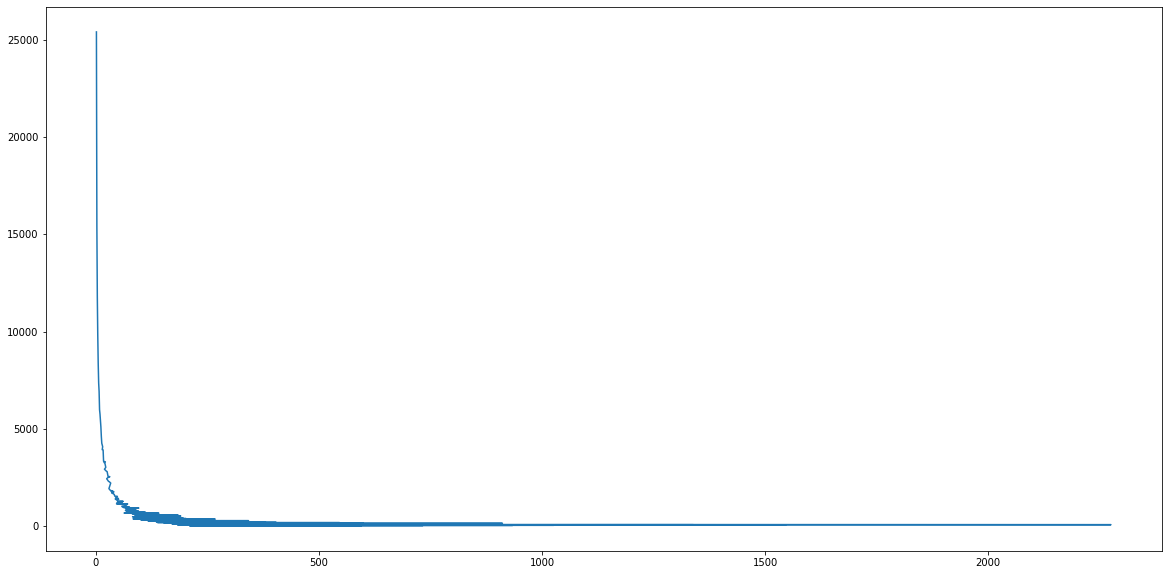

In [66]:
df_table['occur'].value_counts().plot(figsize=(20,10))

In [67]:
df_table['occur'].value_counts()

1      25408
2      15395
3      11777
4       9809
5       8366
       ...  
335       19
286       18
363       15
325        9
382        7
Name: occur, Length: 547, dtype: int64

In [68]:
max_occur = max(df_table['occur'])
df_table['occur'].value_counts().apply(lambda x : log10(x)/log10(max_occur))

1     1.31
2     1.25
3     1.21
4     1.19
5     1.17
      ... 
335   0.38
286   0.37
363   0.35
325   0.28
382   0.25
Name: occur, Length: 547, dtype: float64

In [69]:
pd.set_option('display.max_rows', 250)
max_occur = max(df_table['occur'])
df_occur = pd.DataFrame({'counts':df_table['occur'].value_counts(), 'log10':df_table['occur'].value_counts().apply(lambda x : log10(x)/log10(max_occur))}).reset_index()
df_occur.rename(columns = {'index':'occur'}, inplace=True)
max_log10 = max(df_occur['log10'])
df_occur['log10R'] = df_occur['log10'].apply(lambda x: max_log10-x)

In [70]:
from sklearn import preprocessing
Min_Max_Scaler = preprocessing.MinMaxScaler( feature_range=(0,1) ) # 設定縮放的區間上下限
MinMax_Data = Min_Max_Scaler.fit_transform( df_occur['log10R'].to_numpy().reshape(-1, 1) ) # Data 為原始資料

In [71]:
df_occur['log10R_MinMax'] = pd.DataFrame(MinMax_Data)

In [72]:
pd.set_option('display.float_format',lambda x : '%.2f' % x)
df_occur

,occur,counts,log10,log10R,log10R_MinMax
0,1,25408,1.31,0.00,0.00
1,2,15395,1.25,0.06,0.06
2,3,11777,1.21,0.10,0.09
3,4,9809,1.19,0.12,0.12
4,5,8366,1.17,0.14,0.14
...,...,...,...,...,...
542,335,19,0.38,0.93,0.88
543,286,18,0.37,0.94,0.88
544,363,15,0.35,0.96,0.91
545,325,9,0.28,1.03,0.97


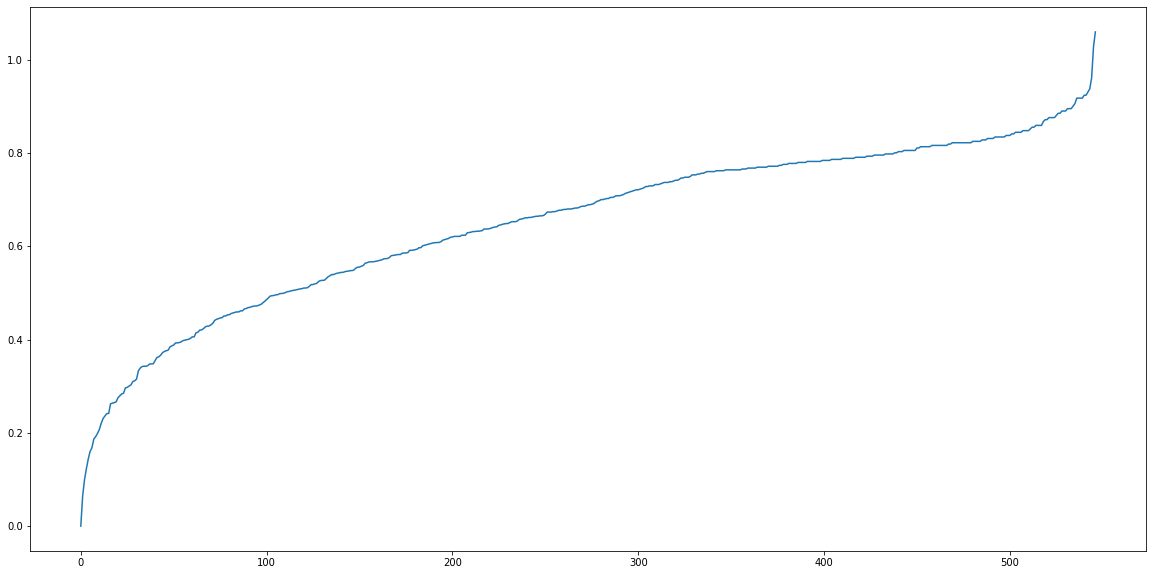

In [73]:
df_occur['log10R'].plot(figsize=(20,10))

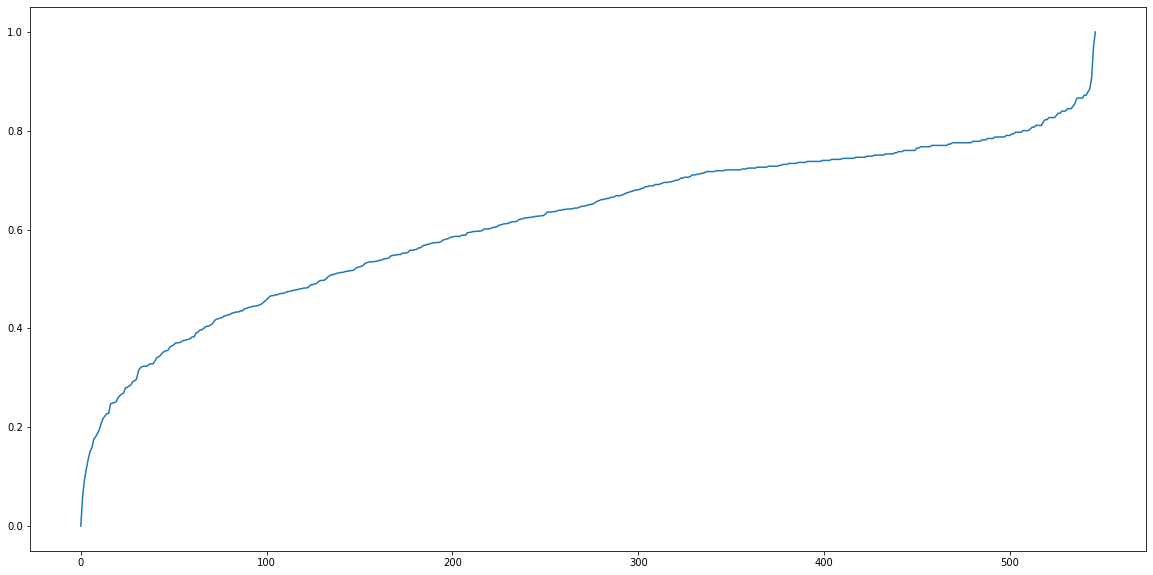

In [74]:
df_occur['log10R_MinMax'].plot(figsize=(20,10))

---

In [75]:
df_occur.drop(['counts', 'log10', 'log10R'], axis=1, inplace=True)
df_occur

,occur,log10R_MinMax
0,1,0.00
1,2,0.06
2,3,0.09
3,4,0.12
4,5,0.14
...,...,...
542,335,0.88
543,286,0.88
544,363,0.91
545,325,0.97


In [76]:
df_table_ok = df_table.join(df_occur.set_index('occur'), on='occur').rename(columns = {'log10R_MinMax':'X_2'})

In [77]:
df_table_ok

,target,next,rank,NN_rank,occur,label,X_2
0,2063176,1793668,53.00,21,35,True,0.33
1,1036421,215370,26.00,73,3,False,0.09
2,4364467,632080,19.00,35,342,False,0.55
3,632080,4272037,20.00,29,648,False,0.77
4,4272037,2454050,14.00,26,99,False,0.47
...,...,...,...,...,...,...,...
308931,2800976,4243503,76.00,89,12,False,0.21
308932,3367985,3066223,25.00,13,68,True,0.43
308933,117092,4597783,91.00,28,139,True,0.48
308934,626850,3821357,10.00,18,53,False,0.37


In [78]:
#將資料分成訓練組及測試組
from sklearn.model_selection import train_test_split

X = df_table_ok.loc[:,['X_2']]
y = df_table_ok['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

In [79]:
#使用決策樹演算法
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [80]:
#評估決策樹模型好壞
predictions = dtree.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

       False       0.56      0.96      0.71     51495
        True       0.50      0.05      0.09     41186

    accuracy                           0.56     92681
   macro avg       0.53      0.50      0.40     92681
weighted avg       0.53      0.56      0.43     92681



In [81]:
print(confusion_matrix(y_test,predictions))

[[49372  2123]
 [39104  2082]]


---

In [82]:
#使用隨機森林與決策樹做比較
from sklearn.ensemble import RandomForestClassifier

#n_estimator代表要使用多少CART樹（CART樹為使用GINI算法的決策樹）
rfc = RandomForestClassifier(n_estimators=100)

#從訓練組資料中建立隨機森林模型
rfc.fit(X_train,y_train)

rfc_pred = rfc.predict(X_test)

In [83]:
#利用classification report來看precision、recall、f1-score、support
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

       False       0.56      0.96      0.71     51495
        True       0.49      0.05      0.09     41186

    accuracy                           0.55     92681
   macro avg       0.52      0.50      0.40     92681
weighted avg       0.53      0.55      0.43     92681



In [84]:
#利用confusion matrix來看實際及預測的差異
print(confusion_matrix(y_test,rfc_pred))

[[49459  2036]
 [39217  1969]]


---

In [85]:
full_table = pd.concat(lt_df_NN_rank[1:], ignore_index=True)

In [86]:
table_grby = full_table.groupby(['target'])
# pd.DataFrame(table_grby.size())

In [87]:
df_table  = pd.merge(pd.DataFrame(table_grby.size()), full_table, on=['target'], how='left')

In [88]:
df_table.rename(columns = {0:'occur'}, inplace=True)

In [89]:
df_table.drop_duplicates(inplace=True, ignore_index=True)
# df_table

In [90]:
df_table['label'] = df_table.apply(lambda df: df['rank'] > df['NN_rank'], axis=1)

In [91]:
# df_table['X_1'] = df_table.apply(lambda df: 1-df['rank']/100, axis=1)

In [92]:
# pd.set_option('display.max_rows', 250)
max_occur = max(df_table['occur'])
df_occur = pd.DataFrame({'counts':df_table['occur'].value_counts(), 'log10':df_table['occur'].value_counts().apply(lambda x : log10(x)/log10(max_occur))}).reset_index()
df_occur.rename(columns = {'index':'occur'}, inplace=True)
max_log10 = max(df_occur['log10'])
df_occur['log10R'] = df_occur['log10'].apply(lambda x: max_log10-x)

In [93]:
from sklearn import preprocessing
Min_Max_Scaler = preprocessing.MinMaxScaler( feature_range=(0,1) ) # 設定縮放的區間上下限
MinMax_Data = Min_Max_Scaler.fit_transform( df_occur['log10R'].to_numpy().reshape(-1, 1) ) # Data 為原始資料

In [94]:
df_occur['log10R_MinMax'] = pd.DataFrame(MinMax_Data)

In [95]:
df_occur.drop(['counts', 'log10', 'log10R'], axis=1, inplace=True)
# df_occur

In [96]:
df_table_ok = df_table.join(df_occur.set_index('occur'), on='occur').rename(columns = {'log10R_MinMax':'X_2'})

In [97]:
# 308936 -4days
df_table_testday = pd.DataFrame(df_table_ok[308936:])
df_table_testday

,target,occur,next,rank,NN_rank,label,X_2
308936,4035865,23,3823964,93.00,4,True,0.25
308937,4035865,23,162741,17.00,27,False,0.25
308938,4035865,23,4923258,25.00,6,True,0.25
308939,4035865,23,2785932,18.00,61,False,0.25
308940,4035930,51,5159258,5.00,2,True,0.35
...,...,...,...,...,...,...,...
470513,999828,902,2101743,19.00,25,False,0.80
470514,999828,902,4763646,36.00,35,True,0.80
470515,999828,902,4793966,68.00,36,True,0.80
470516,999949,1,1062644,4.00,36,False,0.00


In [100]:
#將資料分成訓練組及測試組
from sklearn.model_selection import train_test_split

X = df_table_testday.loc[:,['X_2']]
y = df_table_testday['label']

---

In [101]:
#評估決策樹模型好壞
predictions = dtree.predict(X)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y,predictions))

              precision    recall  f1-score   support

       False       0.56      0.95      0.70     89871
        True       0.47      0.06      0.10     71711

    accuracy                           0.55    161582
   macro avg       0.51      0.50      0.40    161582
weighted avg       0.52      0.55      0.43    161582



In [102]:
print(confusion_matrix(y,predictions))

[[85389  4482]
 [67742  3969]]


---

In [67]:
rfc_pred = rfc.predict(X)
#利用classification report來看precision、recall、f1-score、support
print(classification_report(y,rfc_pred))

              precision    recall  f1-score   support

       False       0.75      0.76      0.75     89871
        True       0.69      0.68      0.69     71711

    accuracy                           0.72    161582
   macro avg       0.72      0.72      0.72    161582
weighted avg       0.72      0.72      0.72    161582



In [68]:
#利用confusion matrix來看實際及預測的差異
print(confusion_matrix(y,rfc_pred))

[[68331 21540]
 [23038 48673]]


---

In [103]:
df_table_testday['pred'] = predictions

In [104]:
df_table_testday['switch'] = df_table_testday.apply(lambda df: df['NN_rank'] if df['pred'] else df['rank'], axis=1)

In [105]:
df_table_testday

,target,occur,next,rank,NN_rank,label,X_2,pred,switch
308936,4035865,23,3823964,93.00,4,True,0.25,False,93.00
308937,4035865,23,162741,17.00,27,False,0.25,False,17.00
308938,4035865,23,4923258,25.00,6,True,0.25,False,25.00
308939,4035865,23,2785932,18.00,61,False,0.25,False,18.00
308940,4035930,51,5159258,5.00,2,True,0.35,False,5.00
...,...,...,...,...,...,...,...,...,...
470513,999828,902,2101743,19.00,25,False,0.80,False,19.00
470514,999828,902,4763646,36.00,35,True,0.80,False,36.00
470515,999828,902,4793966,68.00,36,True,0.80,False,68.00
470516,999949,1,1062644,4.00,36,False,0.00,False,4.00


In [106]:
df_table_testday.describe()

,occur,rank,NN_rank,X_2,switch
count,161582.00,161582.00,161582.00,161582.00,161582.00
mean,126.45,40.82,43.89,0.33,40.82
std,244.12,29.08,29.13,0.20,29.04
min,1.00,1.00,1.00,0.00,1.00
25%,9.00,15.00,18.00,0.18,15.00
50%,39.00,36.00,41.00,0.32,36.00
75%,132.00,65.00,68.00,0.47,65.00
max,2662.00,99.00,99.00,1.00,99.00
